### Counting the number of Capuchinbird calls within a given clip

Download the dataset here -> https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

File Hirearchy -> Voice_Processing/data/...(paste the downloaded, extracted 3 files here)

In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

### Loading the Dataset

Getting the data in a pictorial representation or in a tensor graph, so that we can use Image classification 

In [7]:
CAPUCHIN_FILE  = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [8]:
# Not working for me

# # loading the encoded wav file
# file_contents = tf.io.read_file(CAPUCHIN_FILE)
# # decoding the encoded file
# wav, sample_Rate = tf.audio.decode_wav(file_contents, desired_channels=1)
# print(wav)  
# 
# wav = tf.squeeze(wav, axis=-1)
# print("\nAfter Squeezing: \n", wav)  
# 
# sample_Rate = tf.cast(sample_Rate, dtype=tf.int64)
# print(sample_Rate)
# 
# wav = tfio.audio.resample(wav, rate_in=sample_Rate, rate_out=1600)

In [9]:
def load_wav_16k_mono(filename):
    # Loading the encoded file
    file_contents = tf.io.read_file(filename)

    # Decoding the encoded file
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    # Reducing Dimensions
    wav = tf.squeeze(wav, -1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # print(wav.shape)

    # Resample to whatever the current frequency is to 16000Hz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav


In [10]:
# def load_wav_16k_mono(filename):
#     # Loading the encoded file
#     file_contents = tf.io.read_file(filename)
# 
#     # Decoding the encoded file
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
# 
#     # Reducing Dimensions
#     wav = tf.squeeze(wav, -1)
#     # print(wav.shape)
# 
#     # Converting to NumPy
#     wav = tf.cast(wav, dtype=tf.float32).numpy()  # Convert TensorFlow tensor to NumPy
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64).numpy()  # Convert to NumPy
# 
#     # Resample to whatever the current frequency is to 16000Hz
#     wav_resampled = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
# 
#     # Converting the numpy back to tensor for further processing 
#     wav = tf.convert_to_tensor(wav_resampled, dtype=tf.float32)  # Back to TensorFlow tensor
#     # print(wav.shape)
#     return wav


In [11]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

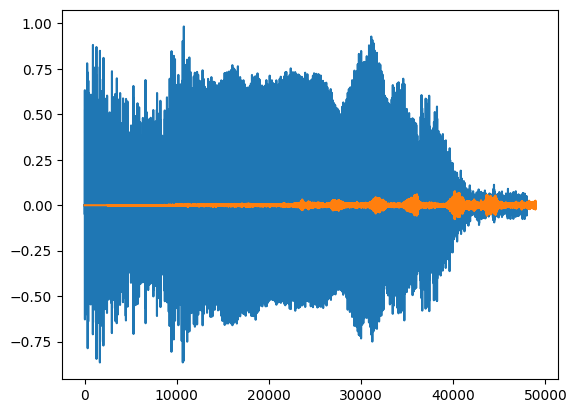

In [12]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Blue one is Capuchin Bird
# Orange one is the background noice

### Creating a Tensorflow Dataset


In [13]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [14]:
# getting each file withing the POS & NEG folders
pos = tf.data.Dataset.list_files(POS + '\*.wav')
neg = tf.data.Dataset.list_files(NEG + '\*.wav')

In [15]:
# Getting a random file -- Just checking
print(pos.as_numpy_iterator().next())
neg.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC433953-6.wav'


b'data\\Parsed_Not_Capuchinbird_Clips\\cricket-sounds-for-sleep-39.wav'

In [16]:
# Assigning a binary number to each pos & neg

# .zip --> is merging two file
# one is pos from earlier 
# and the other is a list of tensors of ones of the same length as pos

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [17]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_Clips\\cricket-sounds-for-sleep-38.wav', 0.0)

### Average Length of a Capuchin Call

In [18]:
# storing the lengths of each audio file in 16000 Hz
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [19]:
# Mean of the Capuchin Audio is 54,156
tf.reduce_mean(lengths)

# 1 sec = 16000 Hz
# ? sec = 54,156 Hz

# print(54156/16000)
# --> 3.38 seconds for an average of Capuchin Bird Voice

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [20]:
# Max length of the file 
tf.reduce_max(lengths)

# 80,000 Hz

# print(80000/16000)
# --> 5 seconds the maximum duration of Capuchin Bird Voice

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [21]:
# Max length of the file 
tf.reduce_min(lengths)

# 32,000 Hz

# print(32000/16000)
# --> 2 seconds the minimum duration of Capuchin Bird Voice

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [22]:
# Let's take the middle, i.e. 48,000

### Converting the data into a spectogram

In [23]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    # only taking the inputs up until 48000
    wav = wav[:48000]
    # for those files whose lengths are less than 48000, we will fill the remaining spaces with zeroes
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    # tf.signal.stft --> short-time fourier transform
    # frame_length --> specifies the length of each frame in samples
    # Each frame --> 320 samples long || At 16Hz sampling rate
    # Frame Duration = 320/16000 = 0.02 seconds --> 20 milliseconds
    # Signal is divided into 20 ms chunks for analysis.

    # frame step -> how much the window will move forward
    # 32/48000 = 0.002 seconds --> 2 milliseconds
    # Moving the window forward by 2 ms (32 samples) each time.
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # removing any negatives
    spectogram = tf.abs(spectogram)
    # encapsulate the spectogram in another set of array (for CNN)
    spectogram = tf.expand_dims(spectogram, axis = 2)

    return spectogram, label


In [24]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)

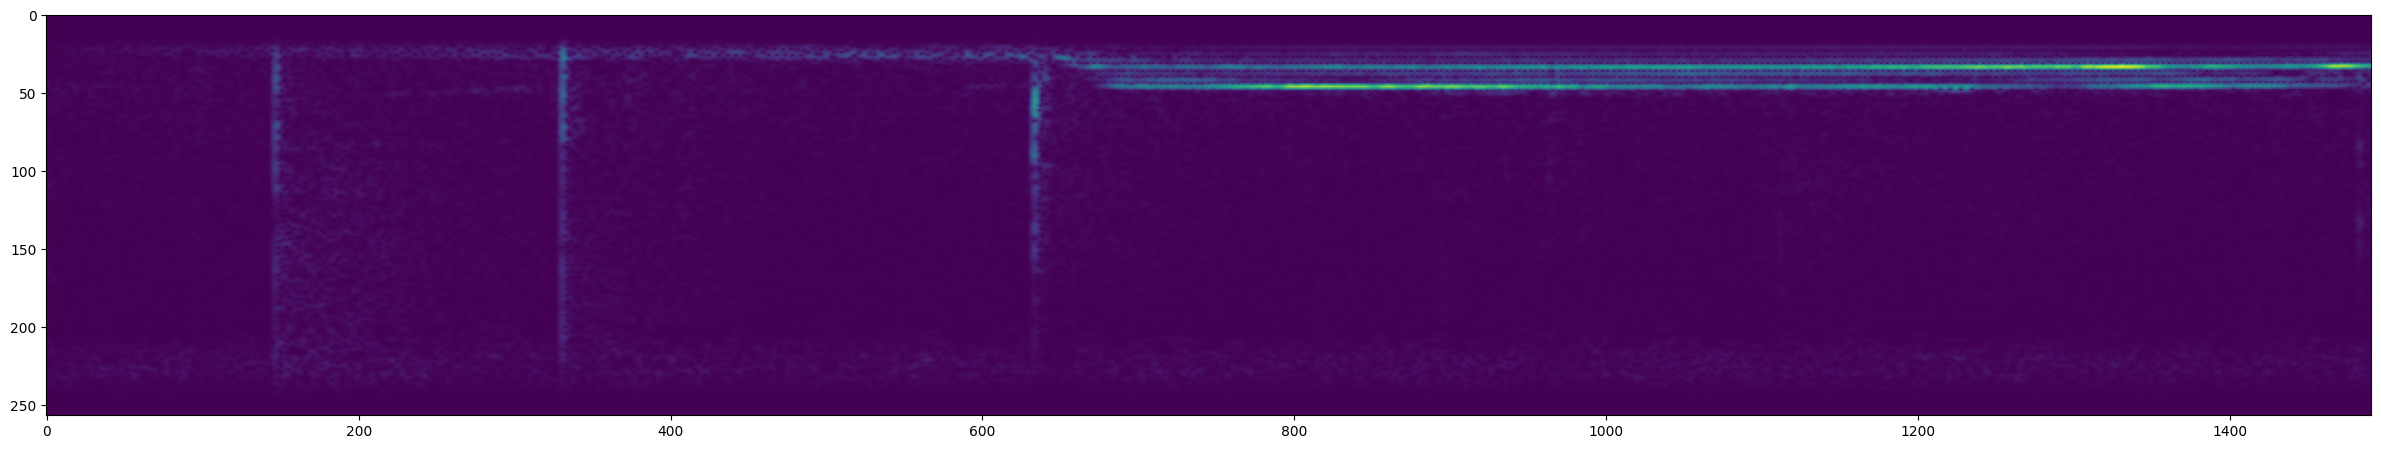

In [32]:
# Visualizing a CAPUCHIN
filepath, label = positives.shuffle(1000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [33]:
spectogram, label = preprocess(filepath, label)

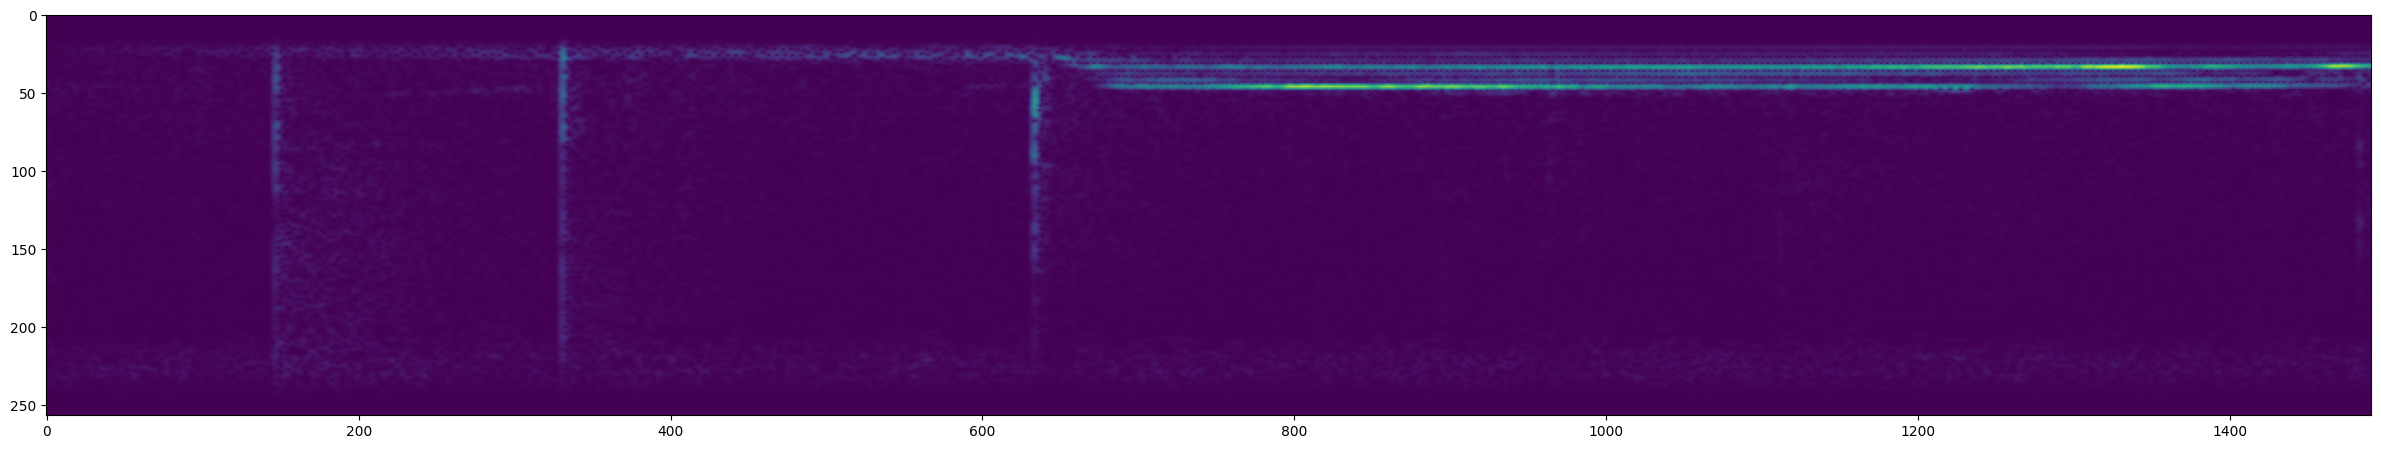

In [34]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

### Create Training and Testing Partitions

In [35]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [36]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>